# Load Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from joblib import dump, load
from imblearn.over_sampling import SMOTE


# Preprocessing


In [2]:
mhs = pd.read_csv('../MHS.csv')
mhs = mhs.drop(columns=['pembimbing_tugas_akhir'])

sa = pd.read_csv('../SA.csv')
krs = pd.read_csv('../KRS.csv')

point_mapping = {
    'Lokal': 1,
    'Provinsi': 3,
    'Nasional': 5,
    'International': 10
}

# Apply mapping
sa['points'] = sa['tingkat_kegiatan'].str.lower().map(point_mapping).fillna(1)

# Calculate total points for each student
sa_points = sa.groupby('npm')['points'].sum().reset_index()
sa_points.rename(columns={'points': 'total_activity_points'}, inplace=True)

# Calculate attendance percentage per course
krs['attendance_percentage'] = (krs['total_hadir'] / krs['total_pertemuan']) * 100


valid_grades = ['A', 'B', 'C', 'D', 'E']
krs['kode_nilai'] = krs['kode_nilai'].apply(lambda x: x if x in valid_grades else 'E')
# Step 2: Count occurrences of each grade per student
grade_counts = krs.pivot_table(
    index='npm', 
    columns='kode_nilai', 
    aggfunc='size', 
    fill_value=0
)

# Rename columns to indicate grade counts
grade_counts.columns = [f'count_kode_nilai_{grade}' for grade in grade_counts.columns]

# Step 3: Merge grade counts with main dataset
mhs = mhs.merge(grade_counts, on='npm', how='left')

# Fill missing counts with 0
mhs.fillna(0, inplace=True)

# Display the final dataset
# print(mhs)
# 
total_sks = krs.groupby('npm')['sks_matakuliah'].sum().reset_index()
total_sks.rename(columns={'sks_matakuliah': 'total_sks'}, inplace=True)

attendance = krs.groupby('npm')['attendance_percentage'].mean().reset_index()
attendance.rename(columns={'attendance_percentage': 'attendance_rate'}, inplace=True)

# Merge SA and KRS aggregated data with MHS.csv

data = mhs.merge(sa_points, on='npm', how='left')
data = data.merge(total_sks, on='npm', how='left')
data = data.merge(attendance, on='npm', how='left')

data.fillna(0, inplace=True)

# Fill missing values (e.g., students with no activities or KRS data)
data['attendance_rate'] = data['attendance_rate'].fillna(0)
data['ipk_mahasiswa'] = data['ipk_mahasiswa'].fillna(0)

data.dropna(inplace=True)

# data['attendance_rate'] = data['total_hadir'] / data['total_pertemuan']
data['activity_count'] = sa.groupby('npm')['nama_kegiatan'].transform('count')
data['activity_count'] = data['activity_count'].fillna(0)


In [3]:
data.head()

,npm,nama_mahasiswa,prodi_mahasiswa,angkatan_mahasiswa,ipk_mahasiswa,status_mahasiswa,count_kode_nilai_A,count_kode_nilai_B,count_kode_nilai_C,count_kode_nilai_D,count_kode_nilai_E,total_activity_points,total_sks,attendance_rate,activity_count
0,1931173,Celine Te,Sistem Informasi,2019,3.87,Lulus,45.0,8.0,0.0,0.0,0.0,18.0,145.0,94.841270,23
1,1931001,Rido Renando,Sistem Informasi,2019,3.72,Lulus,39.0,10.0,4.0,0.0,0.0,26.0,145.0,96.428571,61
2,1931009,Richie Marlon,Sistem Informasi,2019,3.90,Lulus,46.0,7.0,0.0,0.0,0.0,15.0,145.0,88.571429,61
3,1931083,Elvin Whang,Sistem Informasi,2019,3.68,Lulus,37.0,15.0,1.0,0.0,0.0,9.0,145.0,93.831169,53
4,2031001,Robin Sunjaya,Sistem Informasi,2020,3.88,Aktif,46.0,6.0,2.0,0.0,0.0,31.0,149.0,90.527950,53


# Train Model

In [40]:
# Apply SMOTE to balance the dataset
X = data[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count','angkatan_mahasiswa', 'count_kode_nilai_A', 'count_kode_nilai_B',
          'count_kode_nilai_C', 'count_kode_nilai_D', 'count_kode_nilai_E']]
y = (data['status_mahasiswa'].isin(['Drop-out (putus studi)', 'Keluar'])).astype(int)

print(y.value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

# Predict probabilities
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of class 1 (Drop-out or Keluar)

# Convert probabilities to percentages
percentages = probabilities * 100

# Show results
for i, prob in enumerate(percentages):
    print(f"Student {i + 1} - Likelihood of Drop-out: {prob:.2f}%")

status_mahasiswa
0    640
1     33
Name: count, dtype: int64
Student 1 - Likelihood of Drop-out: 0.00%
Student 2 - Likelihood of Drop-out: 0.00%
Student 3 - Likelihood of Drop-out: 0.00%
Student 4 - Likelihood of Drop-out: 0.00%
Student 5 - Likelihood of Drop-out: 2.00%
Student 6 - Likelihood of Drop-out: 0.00%
Student 7 - Likelihood of Drop-out: 8.00%
Student 8 - Likelihood of Drop-out: 1.00%
Student 9 - Likelihood of Drop-out: 1.00%
Student 10 - Likelihood of Drop-out: 2.00%
Student 11 - Likelihood of Drop-out: 1.00%
Student 12 - Likelihood of Drop-out: 0.00%
Student 13 - Likelihood of Drop-out: 0.00%
Student 14 - Likelihood of Drop-out: 2.00%
Student 15 - Likelihood of Drop-out: 0.00%
Student 16 - Likelihood of Drop-out: 0.00%
Student 17 - Likelihood of Drop-out: 0.00%
Student 18 - Likelihood of Drop-out: 0.00%
Student 19 - Likelihood of Drop-out: 0.00%
Student 20 - Likelihood of Drop-out: 0.00%
Student 21 - Likelihood of Drop-out: 0.00%
Student 22 - Likelihood of Drop-out: 55.00%
S

In [41]:
dump(model, 'do-predict.joblib')

['do-predict.joblib']

# Evaluate Model

In [42]:
y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, probabilities))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       127
           1       0.86      0.75      0.80         8

    accuracy                           0.98       135
   macro avg       0.92      0.87      0.89       135
weighted avg       0.98      0.98      0.98       135

ROC AUC Score: 0.9970472440944882


# Visualize Feature Importance

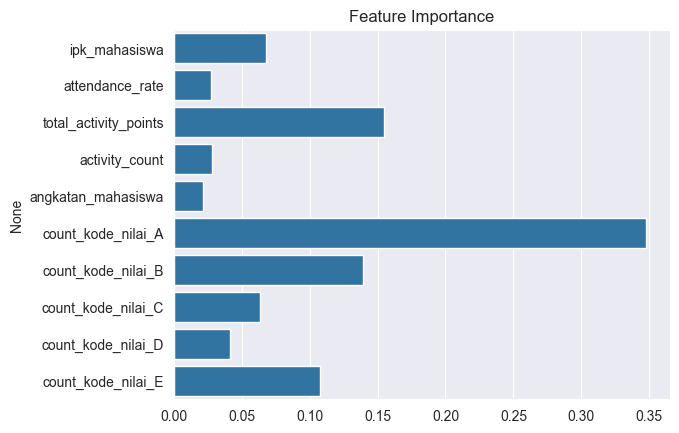

In [37]:
# Plot feature importance
importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()

# Test Model

In [38]:
# model = load('do-predict.joblib')

def predict_do(npm, data):

    data_mhs = data[data['npm'] == npm]

    if data_mhs.empty:
        return f"Data {npm} tidak ditemukan."
    
    nama_mahasiswa = data_mhs['nama_mahasiswa'].values[0]

    features = data_mhs[['ipk_mahasiswa', 'attendance_rate', 'total_activity_points','activity_count','angkatan_mahasiswa', 'count_kode_nilai_A', 'count_kode_nilai_B',
          'count_kode_nilai_C', 'count_kode_nilai_D', 'count_kode_nilai_E']]
    
    # Get the probability of the student being in the "Drop-out" class
    prediction = model.predict_proba(features)[:, 1] * 100  # Use [:, 1] for "Drop-out" probability
    
    # Format and return the prediction
    return f"Mahasiswa {nama_mahasiswa} (NPM: {npm}) diprediksi memiliki kemungkinan DO sebesar: {prediction[0]:.2f}%."

In [39]:
test = predict_do(2031055, data)
print(test)

Mahasiswa Edmund (NPM: 2031055) diprediksi memiliki kemungkinan DO sebesar: 98.00%.


# GridSearch

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=2,
    n_jobs=3,
)

grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")